In [1]:
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import NonDominatedSorting as nds
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import warnings
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [2]:
var_num = 10
problem = get_problem("zdt1", var_num)
 
algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               save_history=True,
               seed=1,
               verbose=False)
 
history = res.history
 
data_list = []
for entry in history:
    gen = entry.n_gen
    pop = entry.pop
    for ind in pop:
        data_dict = {}
        for i, x in enumerate(ind.X):
            data_dict[f"x{i + 1}"] = x
        data_dict["f1"] = ind.F[0]
        data_dict["f2"] = ind.F[1]
        data_dict["gen"] = gen
        data_dict["n_gen"] = np.nan
        data_dict["RANK"] = np.nan
        data_list.append(data_dict)
 


In [3]:
df = pd.DataFrame(data_list)
df.to_csv("ZDT1_10var100gen.csv")

df_only_objectives = df[["f1", "f2"]]
df_only_objectives.to_csv("only_objectives.csv", header=False, index=False)

df = pd.read_csv("ZDT1_10var100gen.csv")


# Make n_gen binary
g_ref = 80
df['n_gen'] = df['gen'].apply(lambda x: 'Ancestors' if x <= g_ref else 'Descendants')

f_data = np.genfromtxt('only_objectives.csv', delimiter=',')
 
nds_obj = nds.NonDominatedSorting()
rank_info= nds_obj.do(f_data, return_rank=True)
 
rank_info_array = rank_info[1]

df['RANK'] = rank_info_array
new_df = df[df['RANK']<=40]

In [4]:

mask_ancestors = new_df['n_gen'] == 'Ancestors'

# n_gen is equal to "Ancestors"
new_df_ans = new_df[mask_ancestors]

# n_gen is not equal to "Ancestors"
new_df_dsc = new_df[~mask_ancestors]

r_partitioning = 2

new_df_ans = new_df_ans.copy()
new_df_dsc = new_df_dsc.copy()

# 1: Good
# 0: Bad
new_df_ans['r_partitioning'] = new_df_ans['RANK'].apply(lambda x: 1 if x <= r_partitioning else 0)
new_df_dsc['r_partitioning'] = new_df_dsc['RANK'].apply(lambda x: 1 if x <= r_partitioning else 0)


columns_ans = [col for col in new_df_ans.columns if col not in ['Unnamed: 0', 'f1', 'f2', 'gen', 'RANK', 'n_gen']]
main_data_ans = new_df_ans[columns_ans]
columns_dsc = [col for col in new_df_dsc.columns if col not in ['Unnamed: 0', 'f1', 'f2', 'gen', 'RANK', 'n_gen']]
main_data_dsc = new_df_dsc[columns_dsc]

In [5]:
target_column = 'r_partitioning'

X_ans = main_data_ans.drop(target_column, axis=1)
y_ans = main_data_ans[target_column]

X_dsc = main_data_dsc.drop(target_column, axis=1)
y_dsc = main_data_dsc[target_column]

#X_ans_encoded = pd.get_dummies(X_ans, columns=['n_gen'])
#X_dsc_encoded = pd.get_dummies(X_dsc, columns=['n_gen'])

# Splitting the datasets into training and testing sets (0.4 test size)
X_train_ans, X_test_ans, y_train_ans, y_test_ans = train_test_split(X_ans, y_ans, test_size=0.3, random_state=42)
X_train_dsc, X_test_dsc, y_train_dsc, y_test_dsc = train_test_split(X_dsc, y_dsc, test_size=0.3, random_state=42)

# Creating and training the Random Forest classifiers
clf_ans = RandomForestClassifier(random_state=42, max_depth = 2, n_estimators = 10)
clf_ans.fit(X_train_ans, y_train_ans)

clf_dsc = RandomForestClassifier(random_state=42)
clf_dsc.fit(X_train_dsc, y_train_dsc)

# Making predictions on the test sets
y_pred_ans = clf_ans.predict(X_test_ans)
y_pred_dsc = clf_dsc.predict(X_test_dsc)

# Evaluating the models
accuracy_ans = accuracy_score(y_test_ans, y_pred_ans)
accuracy_dsc = accuracy_score(y_test_dsc, y_pred_dsc)

print("Accuracy for main_data_ans:", accuracy_ans)
print("Accuracy for main_data_dsc:", accuracy_dsc)

# You can also print other metrics like classification report if needed
print("\nClassification Report for main_data_ans:\n", classification_report(y_test_ans, y_pred_ans))
print("\nClassification Report for main_data_dsc:\n", classification_report(y_test_dsc, y_pred_dsc))


Accuracy for main_data_ans: 0.8567375886524823
Accuracy for main_data_dsc: 0.995

Classification Report for main_data_ans:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      1419
           1       0.73      0.89      0.80       696

    accuracy                           0.86      2115
   macro avg       0.84      0.87      0.85      2115
weighted avg       0.87      0.86      0.86      2115


Classification Report for main_data_dsc:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        48
           1       1.00      1.00      1.00       552

    accuracy                           0.99       600
   macro avg       0.98      0.99      0.98       600
weighted avg       1.00      0.99      1.00       600



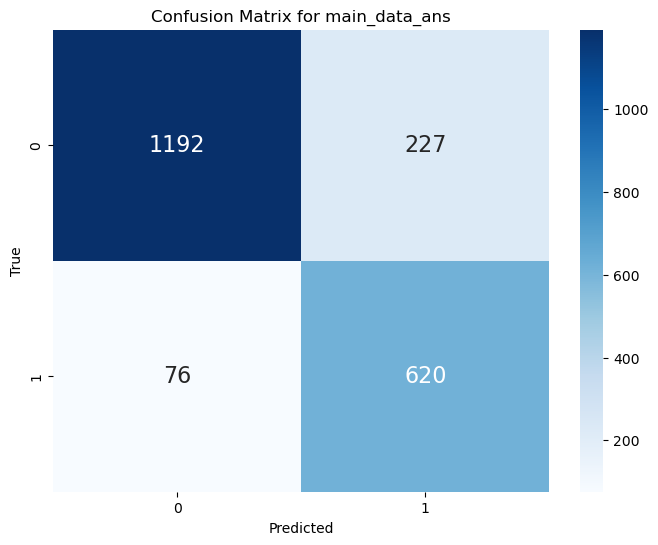

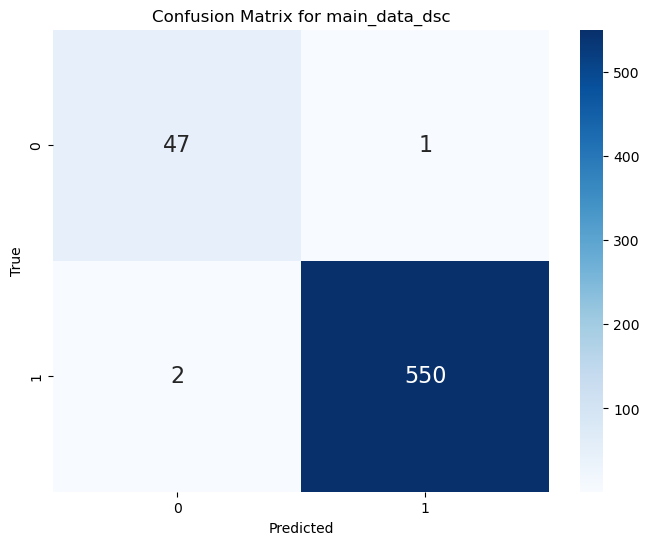

In [6]:
# 1: Good
# 0: Bad

y_pred_ans = clf_ans.predict(X_test_ans)
y_pred_dsc = clf_dsc.predict(X_test_dsc)
cm_ans = confusion_matrix(y_test_ans, y_pred_ans)
cm_dsc = confusion_matrix(y_test_dsc, y_pred_dsc)

# Plot confusion matrix for main_data_ans
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ans, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix for main_data_ans")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot confusion matrix for main_data_dsc
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dsc, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.title("Confusion Matrix for main_data_dsc")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


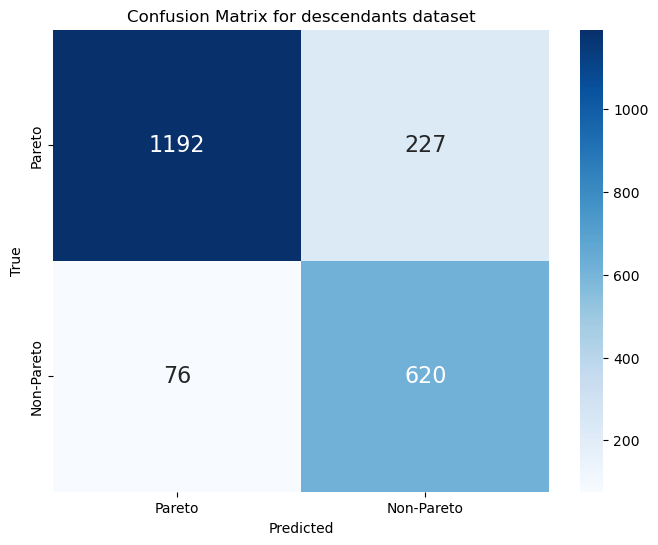

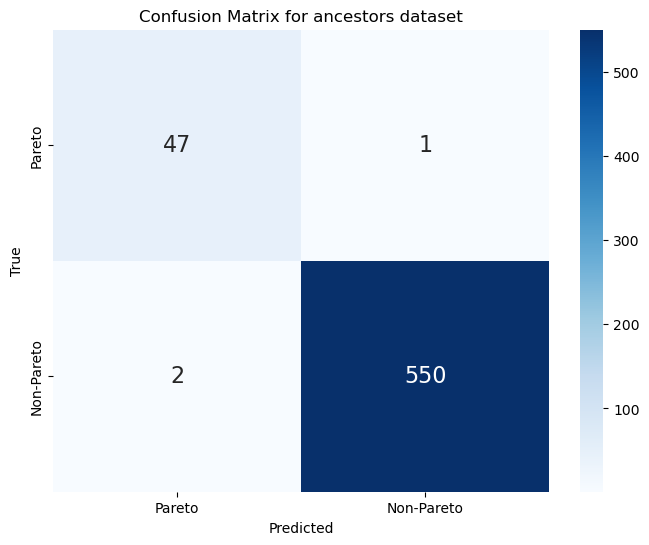

In [9]:
class_labels = ["Pareto", "Non-Pareto"]

# Plot confusion matrix for main_data_ans
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ans, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16},
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for descendants dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot confusion matrix for main_data_dsc
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dsc, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16},
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix for ancestors dataset")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Extracting rules is easier but find what dataset we need to extract rules challenging task